# Part A: Assess the Business Growth

This part explore the business in three aspects:
1. Transactions
    * What is the most important factor in customer satisfaction?
    * On Revenue: Who, What, When, Where? 
        * sales volumn and resulting revenue
        * Who are the top sellers and buyers
        * What products generate the highest revenues 
        * What time of day and days of week experience peak sales?
        * Is there a particular geographic region that generates the most sales?
    * Percent satisfied transactions
    * Average transaction size (measured in payment amount)

2. Buyer Activity 
    * What are the number of active buyers (defined as customers that made repeat purchases in the following month)
    * What is the ratio between returning and first-time buyer? 
3. Seller Activity 
    * How many active seller do we have?
    * Percent buyers rated below 3/5
    * How fast are we adding sellers? Is the rate of addition growing or slowing. 
    * Change in sellers reated below 3/5 overtime to gauge seller quality. 
In terms of the growth of seller, unfortunately, we don't have the complete data, but we have some sampled data which i will use to look at the trend. 

---

Other questions to answer and metrics to track but we don't have data with are:

**Search effectiveness**
* Percent searches for which Olist has at least one item in inventory. 
* The number of searches that return no results. (This is the lost opportunity)
* Change in daily searches per buyer
* Change in new listings per day.
* Are the above two correlated? 
* What buyers are searching for? 
* What are the most common search terms that yield nothing? (This provides insights to supply opportunities)


**Inventory Growth**
* The rate at which sellers are adding new listings and the completeness of those

**Ratings**


* the number of listings 
* the quality of sellers 
* The number of active sellers (defined as seller who created new listing in last 30 days)
* Active listing (defined as at least # views in last week)
* The number of engaged buyers (defined as searched in last 30 days) 
* Percent flagged listings



In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
sns.set()

COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [177]:
# pip install plotly

### 0. Load and Merege Datasets

In [178]:
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_customers = pd.read_csv('data/olist_customers_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
seller = pd.read_csv('data/olist_sellers_dataset.csv')
products = pd.read_csv('data/products.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [179]:
print(f"""Order dataset includes transactions range from 
{orders.order_purchase_timestamp.min()} to {orders.order_purchase_timestamp.max()}
with a total of {len(orders)} orders""")

Order dataset includes transactions range from 
2016-09-04 21:15:19 to 2018-10-17 17:30:18
with a total of 99441 orders


In [180]:
print(orders.shape) 
print(order_items.shape)

(99441, 8)
(112650, 7)


In [181]:
orders_df = (
    orders
    .merge(
        reviews.groupby(['order_id'])['review_score'].mean().round().astype(int).reset_index(),
        on='order_id', how='left'
    )
    .merge(
        order_items.groupby(['order_id']).agg({'price': 'sum', 'product_id': 'count'}).reset_index().rename(columns={'price': 'total_payment', 'product_id': 'num_products'}),
        on='order_id', how='left'
    )
)

## On Transaction

#### I. On Logistics 

In [182]:
orders_delivered = orders_df[orders_df['order_status'].isin(['delivered'])]
# Convert to datetime 
orders_delivered[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders_delivered[
    ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

# Calculate actual delivery time
orders_delivered['days_to_delivery'] = (orders_delivered['order_delivered_customer_date'] - orders_delivered['order_purchase_timestamp']).dt.days

# Calculate estimated delivery time
orders_delivered['estimated_delivery_time'] = (orders_delivered['order_estimated_delivery_date'] - orders_delivered['order_purchase_timestamp']).dt.days

print(f"{len(orders_delivered[orders_delivered['days_to_delivery'].isna()])} of orders that show delivered status has no delivery entries")
print(f"{len(orders_delivered[orders_delivered['estimated_delivery_time'].isna()])} of orders that show delivered status has estiamted delivery time entries")
# 8 orders have no delivery time, could due to data entry error 
# drop these 
orders_delivered = orders_delivered[~orders_delivered['days_to_delivery'].isna()]
orders_delivered['days_to_delivery'] = orders_delivered['days_to_delivery'].astype(int)

orders_delivered['diff_estimated_actual_delivery'] = orders_delivered['estimated_delivery_time'] - orders_delivered['days_to_delivery']

# positive value is good: actual delivery faster than estimated 
# negative value is bad

8 of orders that show delivered status has no delivery entries
0 of orders that show delivered status has estiamted delivery time entries


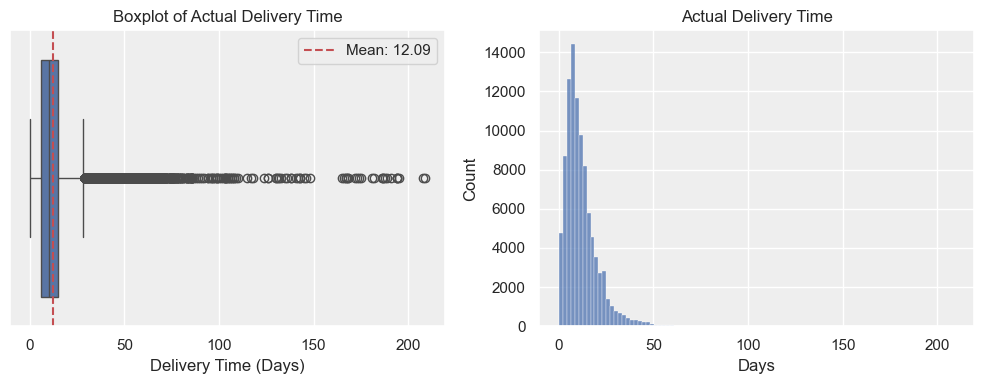

In [183]:
mean_value = orders_delivered['days_to_delivery'].mean()

# Create subplots for the boxplot and histogram
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the boxplot on the first subplot
sns.boxplot(x=orders_delivered['days_to_delivery'], ax=ax[0])
ax[0].axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
ax[0].legend()
ax[0].set_title('Boxplot of Actual Delivery Time')  # Use set_title()
ax[0].set_xlabel('Delivery Time (Days)')  # Use set_xlabel()

# Plot the histogram on the second subplot
sns.histplot(orders_delivered['days_to_delivery'], bins=100, ax=ax[1])
ax[1].set_title('Actual Delivery Time')  # Use set_title()
ax[1].set_xlabel('Days')  # Use set_xlabel()

plt.tight_layout()
plt.show()

In [184]:
orders_delivered['days_to_delivery'].describe()

count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: days_to_delivery, dtype: float64

In [185]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = orders_delivered['days_to_delivery'].quantile(0.25)
Q3 = orders_delivered['days_to_delivery'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = orders_delivered[(orders_delivered['days_to_delivery'] < lower_bound) | 
                            (orders_delivered['days_to_delivery'] > upper_bound)]

print(f"{round(len(outliers) / len(orders_delivered), 2)}% of total orders are outliers, which is not too bad")

0.05% of total orders are outliers, which is not too bad


The e-commerce is operated in Brazil, where an online order takes, on average, 20 days to be delivered (from [Statista](https://www.statista.com/statistics/1117196/delivery-time-e-commerce-brazil/#:~:text=Delivery%20time%20for%20an%20online%20orders%20in%20Brazil%202020&text=As%20of%20March%202020%2C%20an,percent%20and%20reached%2016%20days.)). 

* Olist has an average delivery time slightly around 12 days, which is a good sign.
* 75% of all orders are delivered within 2 weeks. Only 0.05% of total orders are outliers. But these outliers range up to 209 days of delivery time!
* This likely will impact customer experience. But on the other hand, if the estimated time to delivery is close to the actual delivery time, it won't be as bad as expected as customers anticipate long waiting time prior. To test this, I will run a quick decision tree, where the target feature is `review_score`

#### 1) Does delivery time impact customer review?

In [186]:
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,total_payment,num_products,days_to_delivery,estimated_delivery_time,diff_estimated_actual_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4.0,29.99,1.0,8,15,7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,4.0,118.70,1.0,13,19,6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5.0,159.90,1.0,9,26,17
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,5.0,45.00,1.0,13,26,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,5.0,19.90,1.0,2,12,10


In [187]:
orders_delivered['order_purchase_timestamp'] = pd.to_datetime(orders_delivered['order_purchase_timestamp'], errors='coerce')
orders_delivered['order_purchase_year'] = orders_delivered['order_purchase_timestamp'].dt.year
orders_delivered['order_purchase_month'] = orders_delivered['order_purchase_timestamp'].dt.month

In [188]:
# drop rows where review_score is na
dt_df = orders_delivered[~orders_delivered['review_score'].isna()]

<Axes: >

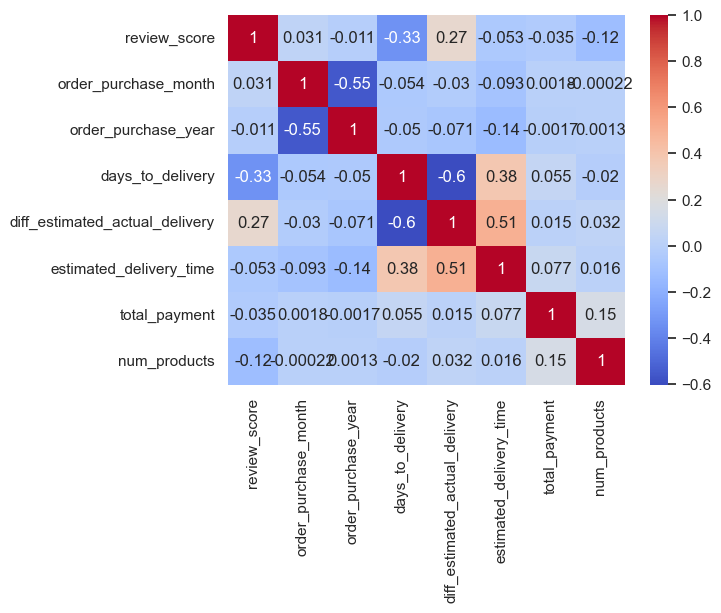

In [189]:
sns.heatmap(dt_df[['review_score', 'order_purchase_month', 
                   'order_purchase_year', 'days_to_delivery', 
                   'diff_estimated_actual_delivery', 'estimated_delivery_time', 
                   'total_payment', 'num_products']].corr(), annot=True, cmap='coolwarm')

As expected, days to delivery is weakly correlated with review_score while estimated_delivery_time is weakly positively correlated with review score. Run a decision tree to see which one is more dominant on review score.

In [190]:
y = dt_df['review_score']
X = dt_df[['days_to_delivery','diff_estimated_actual_delivery', 
            'total_payment', 'num_products']]

In [191]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [10, 20, 30, 40],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1],
                         'min_samples_leaf': [10, 20, 30, 40]},
             scoring='accuracy')

In [192]:
# dt2 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30, class_weight='balanced', min_impurity_decrease=0.001)
# dt2.fit(X1, y)

In [193]:
best_model = grid_search.best_estimator_

In [194]:
grid_search.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10}

In [195]:
dt_df.groupby('order_purchase_year').size()

order_purchase_year
2016      264
2017    43098
2018    52462
dtype: int64

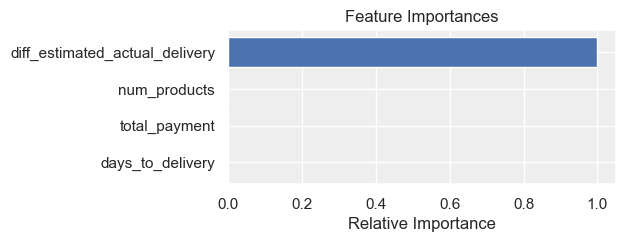

In [196]:
# plot feature importance
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(5, 2))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [197]:
# pip install graphviz

In [198]:
import graphviz 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [199]:
best_model.classes_

array([1., 2., 3., 4., 5.])

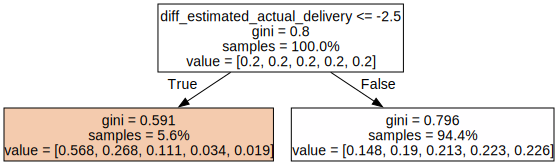

In [200]:
graph = export_graphviz(best_model,
                       feature_names=best_model.feature_names_in_,
                       proportion=True,
                       rotate=False,
                       filled=True)
s = Source(graph)
s

- From this simple decision tree, we can see that the difference between the expected delivery and the actual delivery date is indicative of the customer review score.
- When actual delivery is slower than estimated delivery, the gini value decreases from 0.8 to 0.59, indicating that the samples in this subset are more homogeneous compared to the root node. Around 80% of the samples from this branch have a review score of 1 or 2.
- When the actual delivery is about the same or faster than the estimated delivery. We have more mixed results. Likely when delivery is on time, customers focus on other aspects of the purchase when leaving reviews.

This result suggests that a more prominent negative customer experience is when customers anticipate a faster delivery than the actual delivery time.

In [201]:
# let us now visualize the distribution of review score 

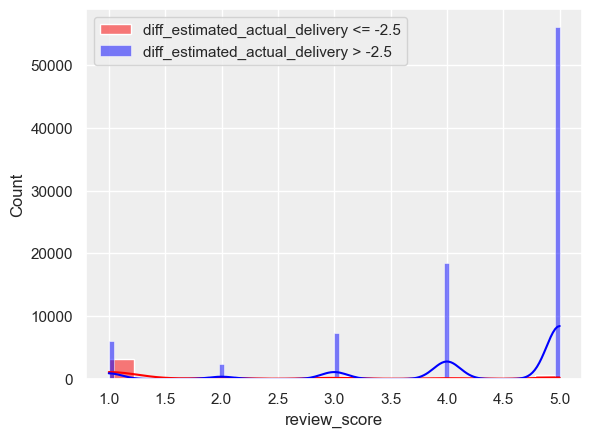

In [202]:
# visualize the distribution of review scores based on whether diff_estimated_actual_delivery is above or below -2.5

sns.histplot(dt_df[dt_df['diff_estimated_actual_delivery'] <= -2.5]['review_score'], color='red', label='diff_estimated_actual_delivery <= -2.5', kde=True)
sns.histplot(dt_df[dt_df['diff_estimated_actual_delivery'] > -2.5]['review_score'], color='blue', label='diff_estimated_actual_delivery > -2.5', kde=True)

plt.legend()

In [203]:
# visualize delay over time
orders_delivered['year'] = orders_delivered['order_purchase_timestamp'].dt.year
orders_delivered['month'] = orders_delivered['order_purchase_timestamp'].dt.month

In [204]:
# group by 'year' and 'month' and perform aggregations
monthly_logistics = orders_delivered.groupby(['year', 'month']).agg(
    min=('diff_estimated_actual_delivery', 'min'),
    max=('diff_estimated_actual_delivery', 'max'),
    mean=('diff_estimated_actual_delivery', 'mean'),
    mode=('diff_estimated_actual_delivery', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    median=('diff_estimated_actual_delivery', 'median')
).reset_index()

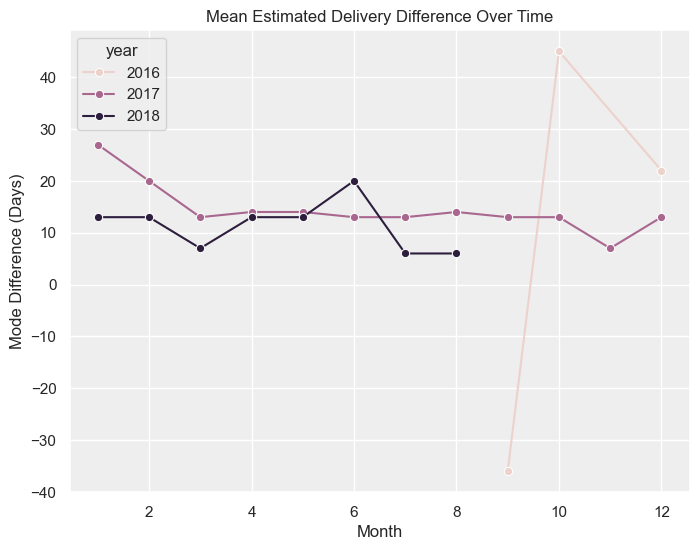

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(x='month', y='mode', hue='year', data=monthly_logistics, marker='o')
plt.title('Mean Estimated Delivery Difference Over Time')
plt.xlabel('Month')
plt.ylabel('Mode Difference (Days)')
plt.show()

Delay improves over time. 

In [206]:
# find out the average transaction size over time and plot them 
orders_delivered['year_month'] = orders_delivered['order_purchase_timestamp'].dt.to_period('M')
monthly_payment = orders_delivered.groupby('year_month').agg(
    mean_payment=('total_payment', 'mean'),
    median_payment=('total_payment', 'median'),
    total_payment=('total_payment', 'sum')
).reset_index()
monthly_payment.head()

,year_month,mean_payment,median_payment,total_payment
0,2016-09,134.970000,134.97,134.97
1,2016-10,152.170226,89.00,40325.11
2,2016-12,10.900000,10.90,10.90
3,2017-01,149.064480,82.65,111798.36
4,2017-02,141.695947,84.90,234223.40


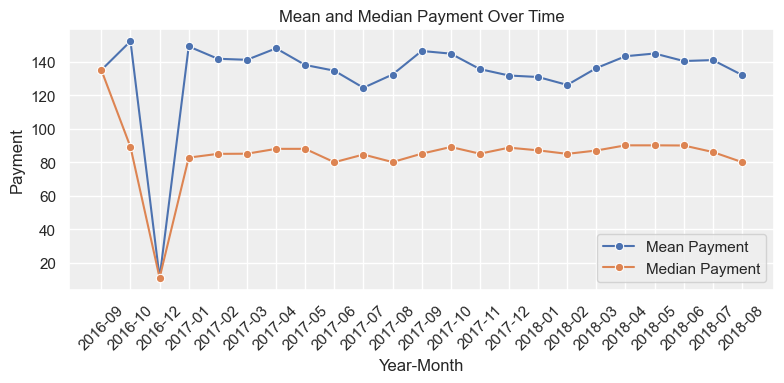

In [207]:
# Convert year_month to string format to ensure it's readable by seaborn
monthly_payment['year_month'] = monthly_payment['year_month'].astype(str)

# Plotting the mean and median payment over time
plt.figure(figsize=(8, 4))
sns.lineplot(x='year_month', y='mean_payment', data=monthly_payment, marker='o', label='Mean Payment')
sns.lineplot(x='year_month', y='median_payment', data=monthly_payment, marker='o', label='Median Payment')

# Adding titles and labels
plt.title('Mean and Median Payment Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Payment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Sudden drop on 2016-12 because there is only a few transaction and the size is small. But other than that, average transaction size are pretty stable around 140. Median transaction size are lower suggesting that some customers make much larger transaction size that skew the data.

### II. On User Growth

In [208]:
transaction = (
    order_items
    .merge(orders, on='order_id', how='left')
    .merge(products[['product_id', 'product_category_name_english']], on='product_id', how='left')
    .merge(order_payments[['order_id', 'payment_value']], on='order_id', how='left')
    .merge(order_customers, on='customer_id', how='left')
    .merge(reviews, on='order_id', how='left')
)

#### 1) Growth of Buyers 

In [209]:
# find out monthly new and returning customers 
customer_df = orders_delivered.merge(order_customers, on='customer_id', how='left')

# compute first purchaes date of each unique customer 
first_purchase_date = (
    customer_df.groupby('customer_unique_id')['order_purchase_timestamp']
    .min()
    .reset_index()
    .rename(columns={'order_purchase_timestamp': 'first_purchase_date'})
)

c_df_full = customer_df.merge(first_purchase_date, on='customer_unique_id', how='left')

In [210]:
c_df_full['first_purchase_year'] = c_df_full['first_purchase_date'].dt.year
c_df_full['first_purchase_month'] = c_df_full['first_purchase_date'].dt.month

c_df_full['customer_type'] = np.where(
    (c_df_full['first_purchase_month'] == c_df_full['order_purchase_month']) 
    & (c_df_full['first_purchase_year'] == c_df_full['order_purchase_year']), 
    'new', 
    'returning'
)

In [211]:
monthly_cus_type = (
    c_df_full
    .groupby(['first_purchase_year', 'first_purchase_month', 'customer_type'])
    ['customer_unique_id'].count().reset_index()
    .pivot_table(
        index=['first_purchase_year', 'first_purchase_month'],
        columns='customer_type',
        values='customer_unique_id'
    ).fillna(0)
).reset_index()

In [212]:
# calculating the percentage change
monthly_cus_type['new_pct_change'] = monthly_cus_type['new'].pct_change() * 100
monthly_cus_type['returning_pct_change'] = monthly_cus_type['returning'].pct_change() * 100

monthly_cus_type['year_month'] = (
    monthly_cus_type['first_purchase_year'].astype(str) 
    + '-' + monthly_cus_type['first_purchase_month'].astype(str).str.zfill(2)
)

monthly_cus_type['returning_new_ratio'] = (monthly_cus_type['returning'] / monthly_cus_type['new']) * 100

In [213]:
monthly_cus_type['monthly_total_cus'] = monthly_cus_type[['new', 'returning']].sum(axis=1)
monthly_cus_type['ratio_new'] = (monthly_cus_type['new'] / monthly_cus_type['monthly_total_cus']) * 100
monthly_cus_type['ratio_returning'] = (monthly_cus_type['returning'] / monthly_cus_type['monthly_total_cus']) * 100

In [214]:
monthly_cus_type_plt = monthly_cus_type.dropna()
monthly_cus_type_plt.head()

customer_type,first_purchase_year,first_purchase_month,new,returning,new_pct_change,returning_pct_change,year_month,returning_new_ratio,monthly_total_cus,ratio_new,ratio_returning
1,2016,10,265.0,10.0,26400.000000,inf,2016-10,3.773585,275.0,96.363636,3.636364
2,2016,12,1.0,1.0,-99.622642,-90.000000,2016-12,100.000000,2.0,50.000000,50.000000
3,2017,1,749.0,34.0,74800.000000,3300.000000,2017-01,4.539386,783.0,95.657727,4.342273
4,2017,2,1651.0,50.0,120.427236,47.058824,2017-02,3.028468,1701.0,97.060553,2.939447
5,2017,3,2541.0,103.0,53.906723,106.000000,2017-03,4.053522,2644.0,96.104387,3.895613


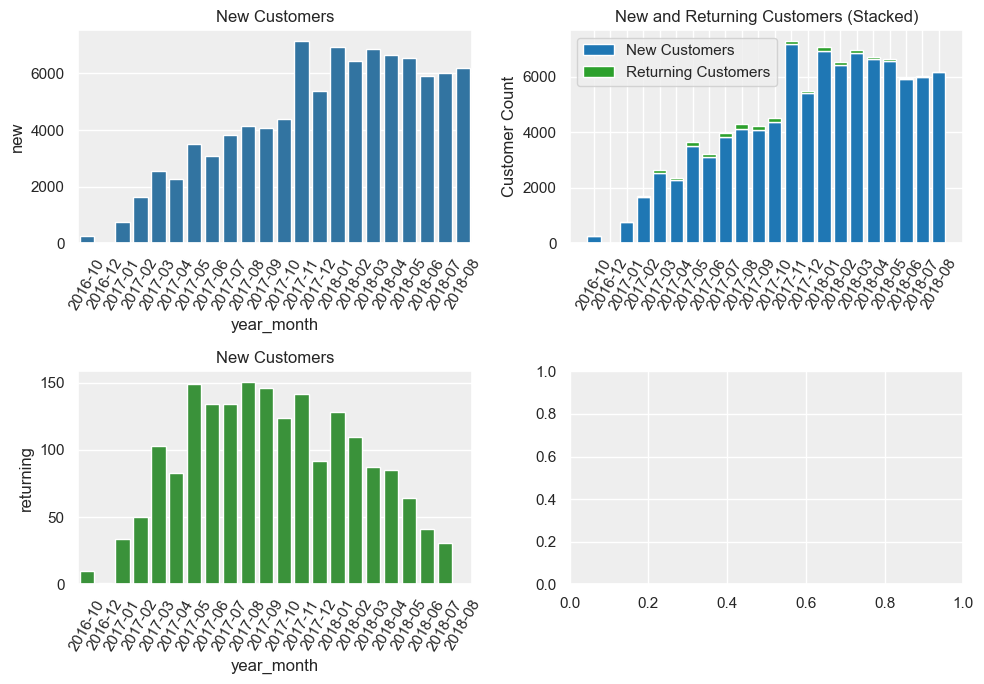

In [215]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Plot barplot for 'new' customers
sns.barplot(x='year_month', y='new', data=monthly_cus_type_plt, ax=ax[0,0], color='tab:blue')
ax[0, 0].set_title('New Customers')
ax[0, 0].set_xticklabels(monthly_cus_type_plt['year_month'], rotation=60)

# Plot stacked bar plot in the third subplot
x = np.arange(len(monthly_cus_type_plt['year_month']))
ax[0, 1].bar(x, monthly_cus_type_plt['new'], label='New Customers', color='tab:blue')
ax[0, 1].bar(x, monthly_cus_type_plt['returning'], bottom=monthly_cus_type_plt['new'], label='Returning Customers', color='tab:green')
ax[0, 1].set_xticks(x)
ax[0, 1].set_xticklabels(monthly_cus_type_plt['year_month'], rotation=60)
ax[0, 1].set_title('New and Returning Customers (Stacked)')
ax[0, 1].set_ylabel('Customer Count')
ax[0, 1].legend()


sns.barplot(x='year_month', y='returning', data=monthly_cus_type_plt, ax=ax[1, 0], color='tab:green')
ax[1, 0].set_title('New Customers')
ax[1, 0].set_xticklabels(monthly_cus_type_plt['year_month'], rotation=60)


# Adjust layout
plt.tight_layout()
plt.show()


New customers grew steadily entering 2017, with the largest month-over-month growth rate occurring in November 2017. This is a positive sign for a start-up during its early stages, as it expands its customer base.

Returning customer experienced a drop. We would like to find out why.
1. What products are returning customers buying? 
2. How satisfied they are with the purchase? (Review data)

New customers are growing. Find out what new customers are purchasing. 

In [216]:
# merge product data with order dataset for revenue calculation 
product_df = (
    order_items
    .merge(products[['product_id', 'product_category_name_english']], on='product_id', how='left')
    .merge(orders, on="order_id", how="left")
)
product_df['rev_per_prod'] = product_df['price'] * 0.1
product_df['order_purchase_timestamp'] = pd.to_datetime(product_df['order_purchase_timestamp'], errors='coerce')
product_df['order_purchase_year'] = product_df['order_purchase_timestamp'].dt.year
product_df['order_purchase_month'] = product_df['order_purchase_timestamp'].dt.month

In [217]:
new_returning_prod = (
    c_df_full
    .merge(product_df, on='order_id', how='right')
    .groupby(['customer_type', 'product_category_name_english'])
    ['product_category_name_english']
    .count().to_frame()
    .rename(columns={'product_category_name_english': 'count_prod'})
    .reset_index()  
    .sort_values(by='count_prod', ascending=False)
)

In [218]:
new_cust_prod_agg = new_returning_prod.query("customer_type == 'new'")
new_cust_prod_agg['pct'] = (new_cust_prod_agg['count_prod'] / new_cust_prod_agg['count_prod'].sum())

In [219]:
return_cust_prod_agg = new_returning_prod.query("customer_type == 'returning'")
return_cust_prod_agg['pct'] = (return_cust_prod_agg['count_prod'] / return_cust_prod_agg['count_prod'].sum())

In [220]:
# function to format pie chart labels conditionally based on percentage
def label_threshold(pct, all_values, labels, threshold=5):
    absolute = int(pct / 100. * sum(all_values))
    return labels if pct > threshold else ''
def autopct_threshold(pct, threshold=5):
    return ('%1.1f%%' % pct) if pct > threshold else ''
    
def plot_pie(df):
    plt.pie(
    df['count_prod'], 
    labels=[
        label_threshold(pct, new_cust_prod_agg['count_prod'], label)
        for pct, label in zip(
            100 * df['count_prod'] / df['count_prod'].sum(),
            df['product_category_name_english']
        )
    ], 
    autopct=lambda pct: autopct_threshold(pct),  
    startangle=90, 
    wedgeprops={'edgecolor': 'white'}
)


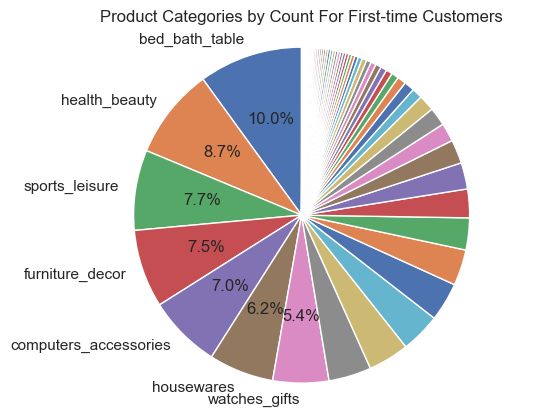

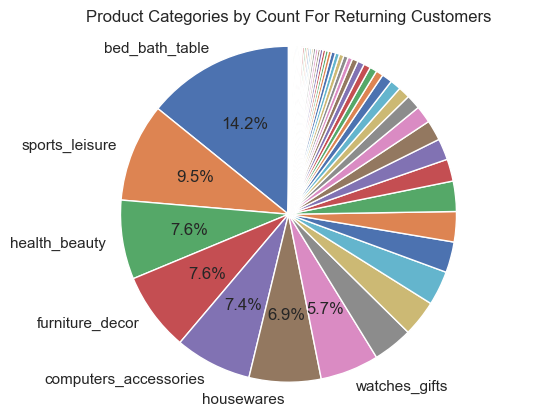

In [221]:
plot_pie(new_cust_prod_agg)
plt.title('Product Categories by Count For First-time Customers')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

plot_pie(return_cust_prod_agg)
plt.title('Product Categories by Count For Returning Customers')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

In [222]:
c_df_full.groupby('customer_type')['review_score'].agg(['mean', 'median']).reset_index()

,customer_type,mean,median
0,new,4.152433,5.0
1,returning,4.328017,5.0


In [223]:
c_df_full.groupby('customer_type')['total_payment'].agg(['mean', 'median']).reset_index()

,customer_type,mean,median
0,new,137.292979,86.50
1,returning,124.441627,86.99


In [224]:
c_df_full.to_csv('c_df_full.csv', index='False')

#### 2) About Sellers

In [225]:
rev_from_prod = (
    product_df
    .groupby(['order_purchase_year', 'order_purchase_month'])
    .agg({'rev_per_prod': 'sum', 'product_id': 'count'})
    .reset_index()
    .rename(columns={'product_id':'num_prod_sold', 'rev_per_prod': 'monthly_rev'})
)

rev_from_prod['order_purchase_date'] = (
    rev_from_prod['order_purchase_year'].astype(str) + '-' + rev_from_prod['order_purchase_month'].astype(str).str.zfill(2)
)
rev_from_prod = rev_from_prod.drop(rev_from_prod.tail(1).index)

In [226]:
# since we don't have data on when the seller join the platform, 
# assume the first join date is the first time they sold an product (this will be an underestimation)
# I will use this data to estimate seller growth and revenues from seller membership fee
seller_min_date = (
    product_df.groupby('seller_id')['order_purchase_timestamp']
    .min()
    .reset_index()
    .rename(columns={'order_purchase_timestamp': 'first_sale_date'})
)

seller_min_date['as_of'] = pd.to_datetime(product_df['order_purchase_timestamp'].max())
seller_min_date['seller_tenure'] = (
    (seller_min_date['as_of'] - seller_min_date['first_sale_date']).dt.days / 30
).round().astype(int)
seller_min_date['sub_rev'] = seller_min_date['seller_tenure'] * 80

In [227]:
# Extract Year-Month from 'first_sale_date'
seller_min_date['first_sale_month'] = seller_min_date['first_sale_date'].dt.to_period('M')

In [228]:
seller_cnt = (
    seller_min_date
    .pivot_table(index='first_sale_month',
                values='seller_id',
                aggfunc='count')
    .reset_index()
)

In [229]:
seller_cnt.head()
# this is an underestimation as it only counts sellers who have successfully 
# sold products as active sellers which is affected by demand 

,first_sale_month,seller_id
0,2016-09,3
1,2016-10,141
2,2016-12,1
3,2017-01,151
4,2017-02,228


In [230]:
seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [231]:
products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [232]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [233]:
# merge review with order_items to find out the percentage of seller that has ratings below 3 

seller_review = (
    order_items
    .merge(reviews, on='order_id', how='left')
    .merge(seller, on='seller_id', how='left')
)

seller_review_df = seller_review.groupby(['seller_id'])['review_score'].mean().reset_index()
seller_review_df['bad_review'] = np.where(seller_review_df['review_score'] < 3, 1, 0)
seller_review_df['bad_review'].mean()

0.11050080775444265

Around 11% of sellers has average reviews below 3, we need to find out why by looking at the review dataset which will be performed in Part C.

In [234]:
seller_review['review_creation_date'] = pd.to_datetime(seller_review['review_creation_date'], errors='coerce')
seller_review['year'] = seller_review['review_creation_date'].dt.year
seller_review['month'] = seller_review['review_creation_date'].dt.month
seller_review['year_month'] = seller_review['year'].astype(str) + '-' + seller_review['month'].astype(str).str.zfill(2)

In [235]:
# calcualte the percent of sellers as a fraction of total sellers in a month that has reviews score below 3
seller_review['bad_review'] = np.where(seller_review['review_score'] < 3, 1, 0)
# calculate the percentage of sellers that has reviews below 3 each month
seller_review_agg = seller_review.groupby(['year_month', 'seller_id'])['bad_review'].max().reset_index()
seller_review_agg = seller_review_agg.groupby('year_month')['bad_review'].mean().reset_index()

# # plot pct of sellesr with bad reviews over time
# plt.figure(figsize=(8, 4))
# sns.lineplot(x='year_month', y='bad_review', data=seller_review_agg, marker='o')
# plt.title('Percentage of Sellers with Bad Reviews Over Time')
# plt.xlabel('Year-Month')
# plt.ylabel('Percentage of Sellers with Bad Reviews')
# plt.xticks(rotation=45)
# plt.grid(True)

seller_review_agg.head()

,year_month,bad_review
0,2016.0-10.0,0.242105
1,2016.0-11.0,0.372549
2,2016.0-12.0,0.638889
3,2017.0-1.0,0.172840
4,2017.0-10.0,0.360677


In [236]:
# read the olist_closed_deals_dataset.csv
closed_deals = pd.read_csv('data/olist_closed_deals_dataset.csv')
closed_deals.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [237]:
# use closed_date to plot the rate of addition of new sellers
closed_deals['closed_date'] = pd.to_datetime(closed_deals['won_date'])
closed_deals['closed_year'] = closed_deals['closed_date'].dt.year
closed_deals['closed_month'] = closed_deals['closed_date'].dt.month

monthly_sellers = closed_deals.groupby(['closed_year', 'closed_month']).size().reset_index().rename(columns={0: 'num_sellers'})

monthly_sellers['closed_date'] = (
    monthly_sellers['closed_year'].astype(str) + '-' + monthly_sellers['closed_month'].astype(str).str.zfill(2)
)

monthly_sellers.head()


,closed_year,closed_month,num_sellers,closed_date
0,2017,12,3,2017-12
1,2018,1,73,2018-01
2,2018,2,113,2018-02
3,2018,3,147,2018-03
4,2018,4,207,2018-04


In [238]:
# calculate the change in number of sellers over time
monthly_sellers['pct_change'] = monthly_sellers['num_sellers'].pct_change() 
monthly_sellers['year_month'] = (
    monthly_sellers['closed_year'].astype(str) + '-' + monthly_sellers['closed_month'].astype(str).str.zfill(2)
)



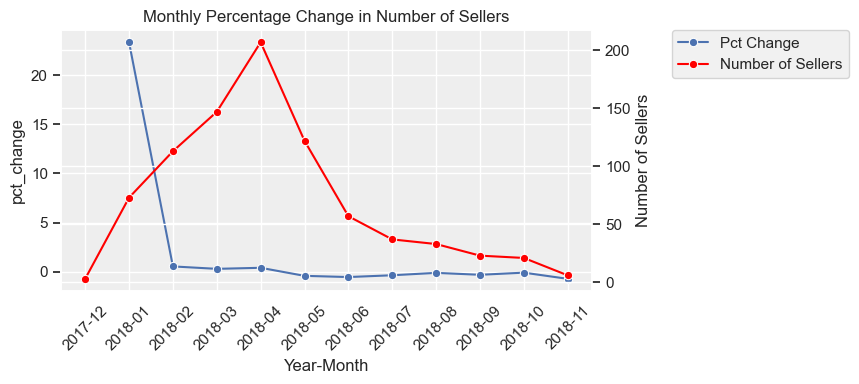

In [239]:
# Create the main figure
plt.figure(figsize=(9, 4))

# Plotting the percentage change in number of sellers on the first axis
ax1 = sns.lineplot(x='year_month', y='pct_change', data=monthly_sellers, marker='o', label='Pct Change', legend=False)
ax1.set_title('Monthly Percentage Change in Number of Sellers')
ax1.set_xlabel('Year-Month')
ax1.grid(True)

# Rotate x-axis tick labels for the primary axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create the second y-axis for the number of sellers
ax2 = ax1.twinx()
sns.lineplot(x='year_month', y='num_sellers', data=monthly_sellers, marker='o', color='red', label='Number of Sellers', legend=False)
ax2.set_ylabel('Number of Sellers')

# Combine legends from both axes and place it outside the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.15, 1), borderaxespad=0.)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()


Based on the sampled data, Olists adds selers at a slower rate overtime. 

### IV. On Revenue:  Who, What, when, and where?


Olists takes a 10% cut on the product price (excluding freight) of each order delivered and a monthly seller fee of 80BRL. Sellers pay 80 BRL. 


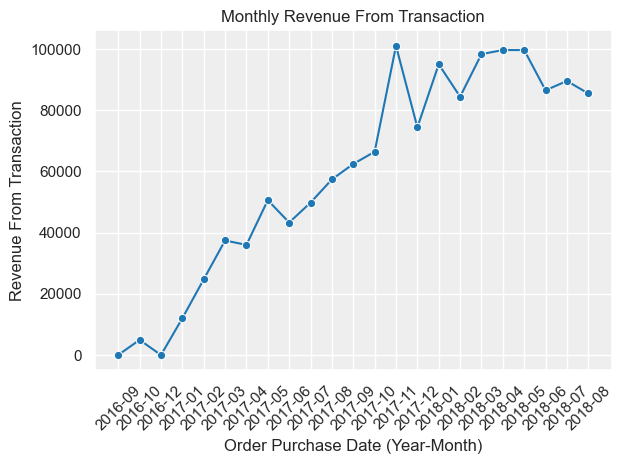

In [240]:
sns.lineplot(x='order_purchase_date', y='monthly_rev', data=rev_from_prod, marker='o', color='tab:blue')

# Set labels and title
plt.xlabel('Order Purchase Date (Year-Month)')
plt.ylabel('Revenue From Transaction')
plt.title('Monthly Revenue From Transaction')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [241]:
print(f"Total Revenue is:{seller_min_date.sub_rev.sum() + rev_from_prod.monthly_rev.sum()}")

Total Revenue is:3972669.87


In [242]:
rev_from_prod.head()

,order_purchase_year,order_purchase_month,monthly_rev,num_prod_sold,order_purchase_date
0,2016,9,26.736,6,2016-09
1,2016,10,4950.766,363,2016-10
2,2016,12,1.090,1,2016-12
3,2017,1,12031.287,955,2017-01
4,2017,2,24730.302,1951,2017-02


#### 1) Who: Top 10 buyers and sellers

Top buyers and sellers in terms of GMV

In [243]:
cust_prod_df = (
    c_df_full
    .merge(order_items, on='order_id', how='right')
).merge(products, on='product_id', how='left')

In [244]:
top_buyers = c_df_full.groupby('customer_unique_id')['total_payment'].sum().nlargest(10)
top_sellers = product_df.groupby('seller_id')['price'].sum().nlargest(10)

In [245]:
top_buyers

customer_unique_id
0a0a92112bd4c708ca5fde585afaa872    13440.0
da122df9eeddfedc1dc1f5349a1a690c     7388.0
763c8b1c9c68a0229c42c9fc6f662b93     7160.0
dc4802a71eae9be1dd28f5d788ceb526     6735.0
459bef486812aa25204be022145caa62     6729.0
ff4159b92c40ebe40454e3e6a7c35ed6     6499.0
4007669dec559734d6f53e029e360987     5934.6
eebb5dda148d3893cdaf5b5ca3040ccb     4690.0
48e1ac109decbb87765a3eade6854098     4590.0
a229eba70ec1c2abef51f04987deb7a5     4400.0
Name: total_payment, dtype: float64

In [246]:
top_sellers

seller_id
4869f7a5dfa277a7dca6462dcf3b52b2    229472.63
53243585a1d6dc2643021fd1853d8905    222776.05
4a3ca9315b744ce9f8e9374361493884    200472.92
fa1c13f2614d7b5c4749cbc52fecda94    194042.03
7c67e1448b00f6e969d365cea6b010ab    187923.89
7e93a43ef30c4f03f38b393420bc753a    176431.87
da8622b14eb17ae2831f4ac5b9dab84a    160236.57
7a67c85e85bb2ce8582c35f2203ad736    141745.53
1025f0e2d44d7041d6cf58b6550e0bfa    138968.55
955fee9216a65b617aa5c0531780ce60    135171.70
Name: price, dtype: float64

In [247]:
cust_prod_df.query('customer_unique_id in @top_buyers.index.to_numpy()').product_category_name_english.unique()

array(['fixed_telephony', 'housewares', 'small_appliances',
       'agro_industry_and_commerce', 'computers', 'watches_gifts', 'art'],
      dtype=object)

In [248]:
cust_prod_df.query('seller_id in @top_sellers.index.to_numpy()').groupby('seller_id')['product_category_name_english'].nunique()

seller_id
1025f0e2d44d7041d6cf58b6550e0bfa     4
4869f7a5dfa277a7dca6462dcf3b52b2    10
4a3ca9315b744ce9f8e9374361493884     7
53243585a1d6dc2643021fd1853d8905     2
7a67c85e85bb2ce8582c35f2203ad736     2
7c67e1448b00f6e969d365cea6b010ab     6
7e93a43ef30c4f03f38b393420bc753a     8
955fee9216a65b617aa5c0531780ce60    23
da8622b14eb17ae2831f4ac5b9dab84a     4
fa1c13f2614d7b5c4749cbc52fecda94     5
Name: product_category_name_english, dtype: int64

In [249]:
cust_prod_df.query('seller_id in @top_sellers.index.to_numpy()')['product_category_name_english'].unique()

array(['bed_bath_table', 'office_furniture', 'cool_stuff',
       'sports_leisure', 'construction_tools_lights', 'watches_gifts',
       'furniture_decor', 'health_beauty', 'electronics', 'baby',
       'computers_accessories', 'signaling_and_security', 'telephony',
       'industry_commerce_and_business', 'home_confort',
       'home_construction', 'housewares', 'consoles_games', 'computers',
       'audio', 'garden_tools', 'stationery', 'home_comfort_2', 'toys',
       'auto', 'agro_industry_and_commerce', 'musical_instruments',
       'construction_tools_construction', 'costruction_tools_tools',
       'fixed_telephony', 'furniture_living_room', 'food',
       'kitchen_dining_laundry_garden_furniture', 'art',
       'small_appliances'], dtype=object)

#### 2) What: What product and categories generate the majority of the revenues?

In [250]:
top_seller_prod = cust_prod_df.query('seller_id in @top_sellers.index.to_numpy()').groupby('product_category_name_english')[['price']].sum().reset_index()
top_seller_prod['pct'] = (top_seller_prod['price'] / top_seller_prod.price.sum()) * 100
top_seller_prod = top_seller_prod.sort_values(by='pct', ascending=False)
top_seller_prod.head(5)

,product_category_name_english,price,pct
34,watches_gifts,562932.53,31.497280
5,bed_bath_table,317527.05,17.766318
27,office_furniture,174992.56,9.791208
16,furniture_decor,167158.83,9.352894
6,computers,166871.75,9.336832


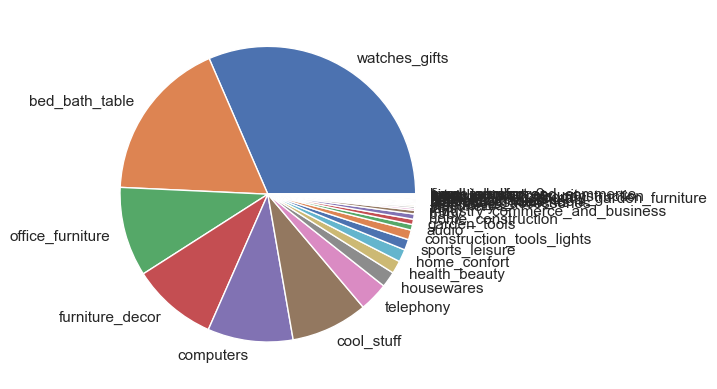

In [251]:
plt.pie(top_seller_prod['pct'], labels=top_seller_prod['product_category_name_english'])
plt.show()

#### 3) When: What time of day, and days of week experience peak sales?

In [252]:
cust_prod_sub = cust_prod_df.query('order_purchase_year == 2017')

In [253]:
# find out dow that expereince peak sales

cust_prod_sub['order_purchase_timestamp'] = pd.to_datetime(cust_prod_df['order_purchase_timestamp'], errors='coerce')
cust_prod_sub['day_of_week'] = cust_prod_sub['order_purchase_timestamp'].dt.day_name()

In [254]:
peak_sale_df = (
    cust_prod_sub
    .groupby(['day_of_week'])  
    .agg({
        'num_products': 'sum',  
        'price': 'sum'          
    })
    .reset_index()
    .rename(columns={         
        'num_products': 'product_count',
        'price': 'total_GMV'
    })
    .sort_values(by=['product_count', 'total_GMV'], ascending=False)  
)

<Axes: xlabel='day_of_week', ylabel='product_count'>

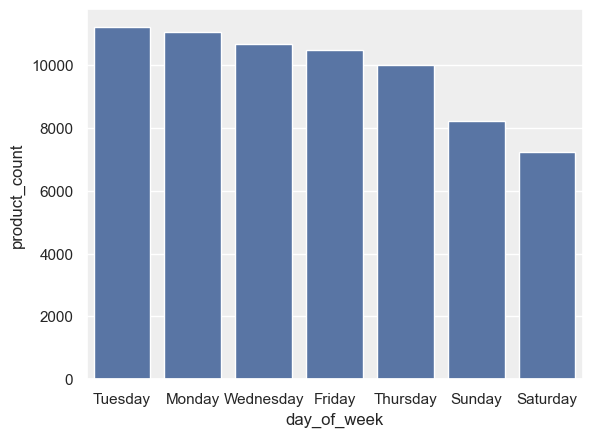

In [255]:
sns.barplot(x='day_of_week', y='product_count', data=peak_sale_df) 

In 2017, sales volumes are evenly spread out from Mon to Thursday. The weekends see the least sales volume.

In [256]:
cust_prod_df.to_csv('cust_prod_df.csv', index=False)

In [257]:
# find time of the day that had peak sales

cust_prod_df['order_purchase_hour'] = cust_prod_df['order_purchase_timestamp'].dt.hour
tod = cust_prod_df['order_purchase_hour'].value_counts().sort_values(ascending=False).reset_index()

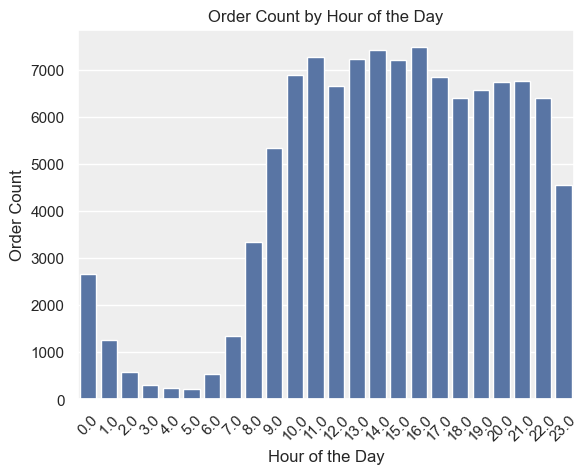

In [258]:
tod.columns = ['hour', 'count']
sns.barplot(x='hour', y='count', data=tod)
plt.title('Order Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Order Count')
plt.xticks(rotation=45) 
plt.show()

#### 4)Where: Is there a particular geographic regions that generate the most sales?

In [259]:
top_rev_state = customer_df.groupby(['customer_state'])[['total_payment']].sum().reset_index().sort_values(by='total_payment', ascending=False)

In [260]:
top_rev_state

,customer_state,total_payment
25,SP,5066562.98
18,RJ,1759651.13
10,MG,1552481.83
22,RS,728718.47
17,PR,666063.51
23,SC,507012.13
4,BA,493584.14
6,DF,296498.41
8,GO,282836.70
7,ES,268643.45
